In [ ]:
pip install earthpy

     |████████████████████████████████| 1.4 MB 9.5 MB/s 
     |████████████████████████████████| 1.0 MB 41.9 MB/s 
     |████████████████████████████████| 19.3 MB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 43.0 MB/s 
     |████████████████████████████████| 16.7 MB 352 kB/s 


In [ ]:
import earthpy as ep

from glob import glob

import earthpy.spatial as es

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

# Specify custom directory to download the dataset

ep.data.path = "."

# Specify the dataset name to download

ep.data.get_data('colorado-flood') 

Extracted output to ./colorado-flood/.


'./colorado-flood/.'

In [ ]:
data = ep.data.get_data('vignette-landsat') 

landsat_path = glob("vignette-landsat/LC08_L1TP_034032_20160621_20170221_01_T1_sr_band*_crop.tif")

landsat_path.sort()

# Stacking Bands
arr_st, meta = es.stack(landsat_path, nodata=-9999)

# Prints meta data 
for i,j in meta.items():
  print("%10s : %s"%(i, str(j)))

    driver : GTiff
     dtype : int16
    nodata : -9999.0
     width : 2158
    height : 1941
     count : 7
       crs : EPSG:32613
 transform : | 30.00, 0.00, 449085.00|
| 0.00,-30.00, 4434855.00|
| 0.00, 0.00, 1.00|
     tiled : False
interleave : band


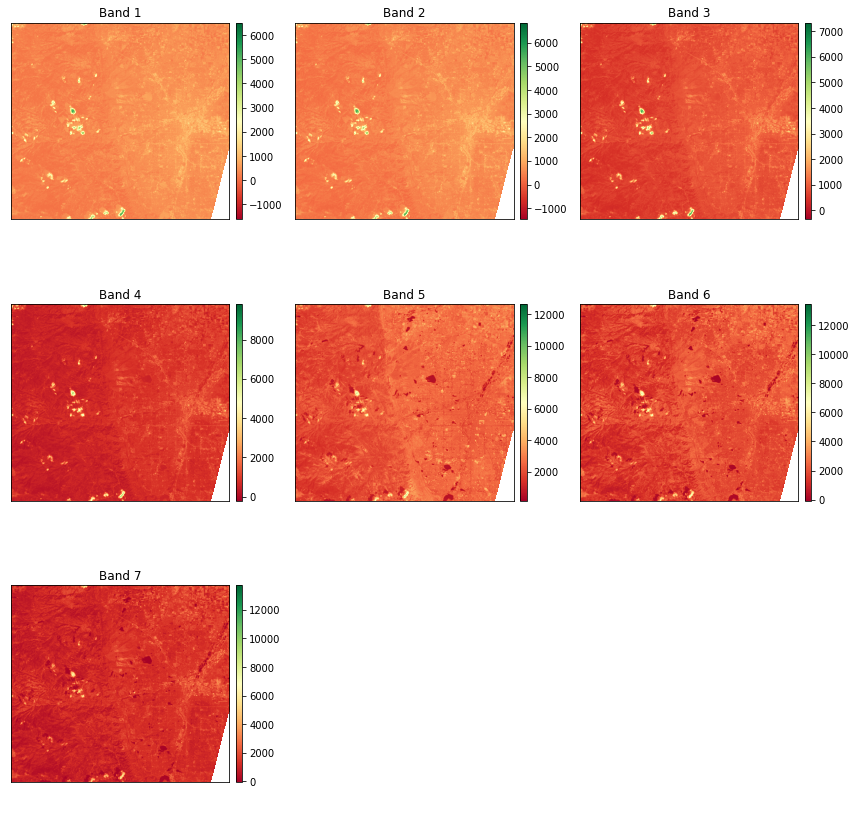

In [ ]:
import earthpy.plot as epp

im = epp.plot_bands(arr_st, cmap='RdYlGn', figsize=(12, 12))

plt.show()

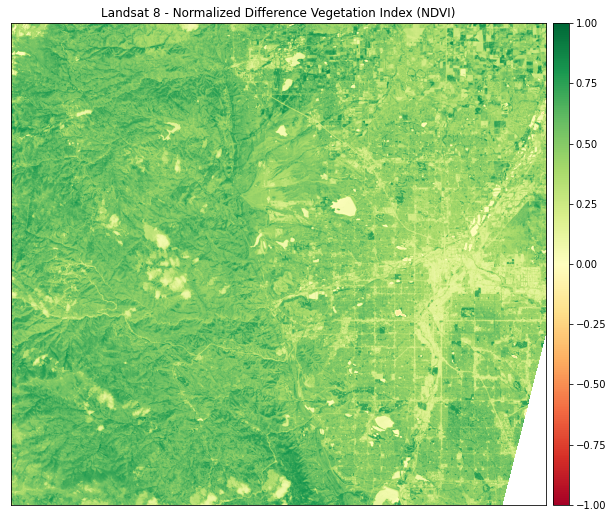

In [ ]:
# Landsat 8 red band is band 4 at [3]
# Landsat 8 near-infrared band is band 5 at [4]

ndvi = es.normalized_diff(arr_st[4], arr_st[3])

titles = ["Landsat 8 - Normalized Difference Vegetation Index (NDVI)"]

epp.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=titles, vmin=-1, vmax=1, figsize=(10, 10))

plt.show()

In [ ]:
from collections import Counter

[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]]


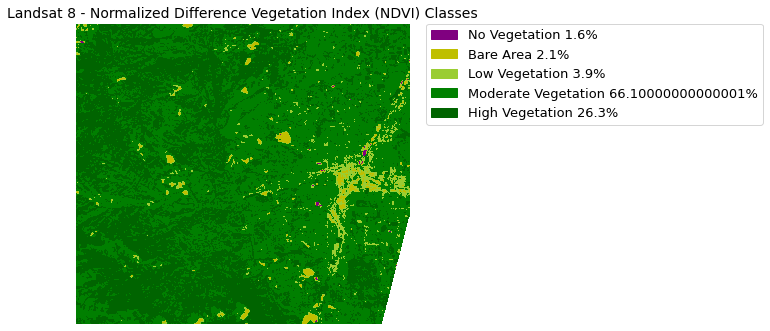

In [ ]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.15, 0.23, 0.6, np.inf]


ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)
print(ndvi_landsat_class)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(np.ma.getmask(ndvi), ndvi_landsat_class)

# Get counting of each class
counts = Counter(ndvi_landsat_class.data.flatten())

# Get the average
_sum = sum(counts.values())
for idx, val in counts.items():
  counts[idx] = np.round(val/_sum,3)

nbr_colors = ["purple", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
]

for i in range(len(ndvi_cat_names)):
  ndvi_cat_names[i] += " " + str(counts[i+1]*100) + "%"

# Get list of classes
classes = np.unique(ndvi_landsat_class)

classes = classes.tolist()

# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)

epp.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)

ax.set_title(
    "Landsat 8 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)

ax.set_axis_off()

# Auto adjust subplot to fit figure size

plt.tight_layout()


In [ ]:
ndvi_landsat_class.data.flatten()

array([4, 4, 4, ..., 1, 1, 1])

In [ ]:
np.ma.getmask(ndvi)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [ ]:
all_data = ndvi.data.flatten()
positive = [x for x in all_data if x>0]

(array([4.979400e+04, 2.193960e+05, 3.739700e+05, 9.139710e+05,
        1.410181e+06, 9.468140e+05, 2.045370e+05, 1.802000e+03,
        6.000000e+00, 7.000000e+00]),
 array([1.78221351e-04, 1.19157506e-01, 2.38136791e-01, 3.57116076e-01,
        4.76095361e-01, 5.95074646e-01, 7.14053931e-01, 8.33033216e-01,
        9.52012501e-01, 1.07099179e+00, 1.18997107e+00]),
 <a list of 10 Patch objects>)

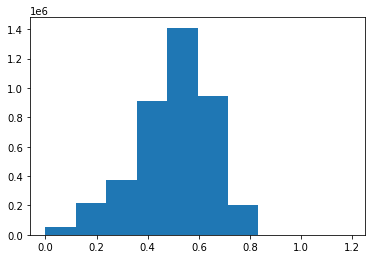

In [ ]:
plt.hist(positive)

(array([  68089.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,   89146.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,  161617.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
        2769380.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1100446.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
        3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
        4.9, 5. ]),
 <a list of 40 Patch objects>)

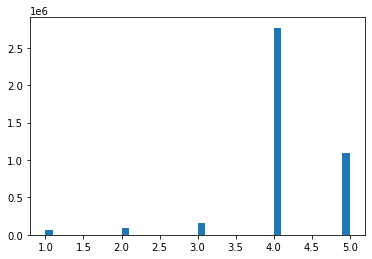

In [ ]:
plt.hist(ndvi_landsat_class.flatten(), bins=40)

In [ ]:
np.percentile(ndvi.data.flatten(), 100)

1.1899710703953712